Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Packages

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras import models
from PIL import Image 
from skimage.io import imread
import cv2
import os
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

n_classes = 21
batch_size = 32
img_width, img_height = 299, 299

train_data_dir = '/content/drive/MyDrive/Nivarsha/Implementation/dataset/train'

# Data Augmentation with ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

val_data_dir = '/content/drive/MyDrive/Nivarsha/Implementation/dataset/test'

val_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 926 images belonging to 21 classes.
Found 210 images belonging to 21 classes.


In [ ]:
class_map = train_generator.class_indices
class_map

{'burger': 0,
 'chapati': 1,
 'chicken': 2,
 'chilliparotta': 3,
 'cornflakes': 4,
 'crispychicken': 5,
 'curdrice': 6,
 'dosa': 7,
 'frenchfries': 8,
 'idli': 9,
 'kesari': 10,
 'lemonrice': 11,
 'naan': 12,
 'oats': 13,
 'paneergravy': 14,
 'pizza': 15,
 'puttu': 16,
 'shawarmaa': 17,
 'vada': 18,
 'venpongal': 19,
 'vermicelli': 20}

Model Training

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

nb_train_samples = 926 #Training Samples
nb_validation_samples = 210 #Testing Samples

inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
model.summary()

In [ ]:

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='v1_inceptionV3', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_v1_inceptionV3.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=val_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=25,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

87910968/87910968 [==============================] - 1s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
<ipython-input-6-a028f5ee2e5d>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/25
28/28 [==============================] - ETA: 0s - loss: 3.3391 - accuracy: 0.0459
Epoch 1: val_loss improved from inf to 3.27166, saving model to v1_inceptionV3


28/28 [==============================] - 370s 13s/step - loss: 3.3391 - accuracy: 0.0459 - val_loss: 3.2717 - val_accuracy: 0.0729
Epoch 2/25
28/28 [==============================] - ETA: 0s - loss: 3.2448 - accuracy: 0.0705
Epoch 2: val_loss improved from 3.27166 to 3.18994, saving model to v1_inceptionV3


28/28 [==============================] - 70s 3s/step - loss: 3.2448 - accuracy: 0.0705 - val_loss: 3.1899 - val_accuracy: 0.1354
Epoch 3/25
28/28 [==============================] - ETA: 0s - loss: 3.1369 - accuracy: 0.1119
Epoch 3: val_loss improved from 3.18994 to 3.12346, saving model to v1_inceptionV3


28/28 [==============================] - 70s 3s/step - loss: 3.1369 - accuracy: 0.1119 - val_loss: 3.1235 - val_accuracy: 0.1146
Epoch 4/25
28/28 [==============================] - ETA: 0s - loss: 3.0745 - accuracy: 0.1253
Epoch 4: val_loss improved from 3.12346 to 3.04034, saving model to v1_inceptionV3


28/28 [==============================] - 69s 2s/step - loss: 3.0745 - accuracy: 0.1253 - val_loss: 3.0403 - val_accuracy: 0.1562
Epoch 5/25
28/28 [==============================] - ETA: 0s - loss: 2.9893 - accuracy: 0.1745
Epoch 5: val_loss improved from 3.04034 to 2.96968, saving model to v1_inceptionV3


28/28 [==============================] - 69s 2s/step - loss: 2.9893 - accuracy: 0.1745 - val_loss: 2.9697 - val_accuracy: 0.1823
Epoch 6/25
28/28 [==============================] - ETA: 0s - loss: 2.9127 - accuracy: 0.2103
Epoch 6: val_loss improved from 2.96968 to 2.92013, saving model to v1_inceptionV3


28/28 [==============================] - 71s 3s/step - loss: 2.9127 - accuracy: 0.2103 - val_loss: 2.9201 - val_accuracy: 0.2083
Epoch 7/25
28/28 [==============================] - ETA: 0s - loss: 2.8373 - accuracy: 0.2617
Epoch 7: val_loss improved from 2.92013 to 2.83190, saving model to v1_inceptionV3


28/28 [==============================] - 70s 3s/step - loss: 2.8373 - accuracy: 0.2617 - val_loss: 2.8319 - val_accuracy: 0.2812
Epoch 8/25
28/28 [==============================] - ETA: 0s - loss: 2.7627 - accuracy: 0.3110
Epoch 8: val_loss improved from 2.83190 to 2.76588, saving model to v1_inceptionV3


28/28 [==============================] - 69s 2s/step - loss: 2.7627 - accuracy: 0.3110 - val_loss: 2.7659 - val_accuracy: 0.3854
Epoch 9/25
28/28 [==============================] - ETA: 0s - loss: 2.6684 - accuracy: 0.3781
Epoch 9: val_loss improved from 2.76588 to 2.66337, saving model to v1_inceptionV3


28/28 [==============================] - 71s 3s/step - loss: 2.6684 - accuracy: 0.3781 - val_loss: 2.6634 - val_accuracy: 0.4271
Epoch 10/25
28/28 [==============================] - ETA: 0s - loss: 2.5834 - accuracy: 0.4195
Epoch 10: val_loss improved from 2.66337 to 2.60321, saving model to v1_inceptionV3


28/28 [==============================] - 68s 2s/step - loss: 2.5834 - accuracy: 0.4195 - val_loss: 2.6032 - val_accuracy: 0.4896
Epoch 11/25
28/28 [==============================] - ETA: 0s - loss: 2.4989 - accuracy: 0.4485
Epoch 11: val_loss improved from 2.60321 to 2.52185, saving model to v1_inceptionV3


28/28 [==============================] - 71s 3s/step - loss: 2.4989 - accuracy: 0.4485 - val_loss: 2.5218 - val_accuracy: 0.5156
Epoch 12/25
28/28 [==============================] - ETA: 0s - loss: 2.3904 - accuracy: 0.5045
Epoch 12: val_loss improved from 2.52185 to 2.42250, saving model to v1_inceptionV3


28/28 [==============================] - 69s 3s/step - loss: 2.3904 - accuracy: 0.5045 - val_loss: 2.4225 - val_accuracy: 0.5417
Epoch 13/25
28/28 [==============================] - ETA: 0s - loss: 2.2850 - accuracy: 0.5738
Epoch 13: val_loss improved from 2.42250 to 2.34689, saving model to v1_inceptionV3


28/28 [==============================] - 69s 2s/step - loss: 2.2850 - accuracy: 0.5738 - val_loss: 2.3469 - val_accuracy: 0.5729
Epoch 14/25
28/28 [==============================] - ETA: 0s - loss: 2.1969 - accuracy: 0.6018
Epoch 14: val_loss improved from 2.34689 to 2.24664, saving model to v1_inceptionV3


28/28 [==============================] - 70s 3s/step - loss: 2.1969 - accuracy: 0.6018 - val_loss: 2.2466 - val_accuracy: 0.6094
Epoch 15/25
28/28 [==============================] - ETA: 0s - loss: 2.1181 - accuracy: 0.6264
Epoch 15: val_loss improved from 2.24664 to 2.14798, saving model to v1_inceptionV3


28/28 [==============================] - 70s 3s/step - loss: 2.1181 - accuracy: 0.6264 - val_loss: 2.1480 - val_accuracy: 0.6354
Epoch 16/25
28/28 [==============================] - ETA: 0s - loss: 1.9804 - accuracy: 0.6596
Epoch 16: val_loss improved from 2.14798 to 2.03662, saving model to v1_inceptionV3


28/28 [==============================] - 70s 3s/step - loss: 1.9804 - accuracy: 0.6596 - val_loss: 2.0366 - val_accuracy: 0.7031
Epoch 17/25
28/28 [==============================] - ETA: 0s - loss: 1.9127 - accuracy: 0.6935
Epoch 17: val_loss improved from 2.03662 to 1.95640, saving model to v1_inceptionV3


28/28 [==============================] - 68s 2s/step - loss: 1.9127 - accuracy: 0.6935 - val_loss: 1.9564 - val_accuracy: 0.6927
Epoch 18/25
28/28 [==============================] - ETA: 0s - loss: 1.8060 - accuracy: 0.7125
Epoch 18: val_loss improved from 1.95640 to 1.84866, saving model to v1_inceptionV3


28/28 [==============================] - 70s 3s/step - loss: 1.8060 - accuracy: 0.7125 - val_loss: 1.8487 - val_accuracy: 0.7396
Epoch 19/25
28/28 [==============================] - ETA: 0s - loss: 1.6784 - accuracy: 0.7617
Epoch 19: val_loss improved from 1.84866 to 1.72934, saving model to v1_inceptionV3


28/28 [==============================] - 69s 3s/step - loss: 1.6784 - accuracy: 0.7617 - val_loss: 1.7293 - val_accuracy: 0.7708
Epoch 20/25
28/28 [==============================] - ETA: 0s - loss: 1.6135 - accuracy: 0.7729
Epoch 20: val_loss improved from 1.72934 to 1.65481, saving model to v1_inceptionV3


28/28 [==============================] - 70s 3s/step - loss: 1.6135 - accuracy: 0.7729 - val_loss: 1.6548 - val_accuracy: 0.7865
Epoch 21/25
28/28 [==============================] - ETA: 0s - loss: 1.5096 - accuracy: 0.8009
Epoch 21: val_loss improved from 1.65481 to 1.59973, saving model to v1_inceptionV3


28/28 [==============================] - 72s 3s/step - loss: 1.5096 - accuracy: 0.8009 - val_loss: 1.5997 - val_accuracy: 0.7865
Epoch 22/25
28/28 [==============================] - ETA: 0s - loss: 1.4096 - accuracy: 0.8154
Epoch 22: val_loss improved from 1.59973 to 1.50295, saving model to v1_inceptionV3


28/28 [==============================] - 69s 3s/step - loss: 1.4096 - accuracy: 0.8154 - val_loss: 1.5029 - val_accuracy: 0.7760
Epoch 23/25
28/28 [==============================] - ETA: 0s - loss: 1.3414 - accuracy: 0.8322
Epoch 23: val_loss improved from 1.50295 to 1.44261, saving model to v1_inceptionV3


28/28 [==============================] - 70s 3s/step - loss: 1.3414 - accuracy: 0.8322 - val_loss: 1.4426 - val_accuracy: 0.7812
Epoch 24/25
28/28 [==============================] - ETA: 0s - loss: 1.2926 - accuracy: 0.8098
Epoch 24: val_loss improved from 1.44261 to 1.36697, saving model to v1_inceptionV3


28/28 [==============================] - 72s 3s/step - loss: 1.2926 - accuracy: 0.8098 - val_loss: 1.3670 - val_accuracy: 0.8073
Epoch 25/25
28/28 [==============================] - ETA: 0s - loss: 1.2126 - accuracy: 0.8479
Epoch 25: val_loss improved from 1.36697 to 1.28586, saving model to v1_inceptionV3


28/28 [==============================] - 70s 3s/step - loss: 1.2126 - accuracy: 0.8479 - val_loss: 1.2859 - val_accuracy: 0.8177


Save the Model

In [ ]:
model.save('/content/drive/MyDrive/Nivarsha/Implementation/Model/model_v1.h5')

Accuray and Loss Graph

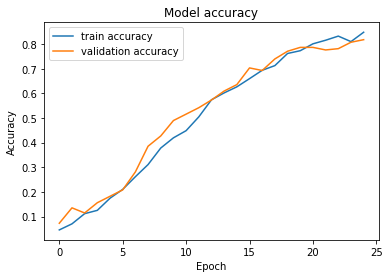

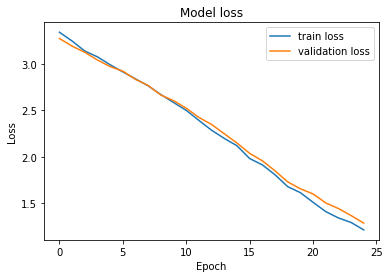

In [ ]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(history)
plot_loss(history)

Load the model

In [ ]:
path_to_model='/content/drive/MyDrive/Nivarsha/Implementation/Model/model_v1.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model('/content/drive/MyDrive/Nivarsha/Implementation/Model/model_v1.h5')

In [ ]:
category={
  0 : ['burger','Burger'], 1 : ['chapati','Chapati'], 2 : ['chicken','Chicken']
  ,3 : ['chilliparotta','Chilli Parotta'], 4 :['cornflakes','Corn Flakes'], 5 : ['crispychicken','Crispy Chicken'],
  6 : ['curdrice','Curd Rice'], 7 : ['dosa','Dosa'], 8 : ['frenchfires','French Fries'], 9 :['idli','Idli'], 10 :['kesari','Kesari'],
  11 : ['lemonrice','Lemon Rice'], 12:['naan','Naan'], 13 : ['oats','Oats'], 14: ['paneergravy','Paneer Gravy'],
  15 : ['pizza','Pizza'], 16 : ['puttu','Puttu'], 17 :['shawarmaa','Shawarmaa'], 18 : ['vada','Vada'],
  19 : ['venpongal','Ven Pongal'], 20 :['vermicelli','Vermicelli']
}

Prediction Function

In [ ]:
def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(299, 299))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index][1]))
    plt.imshow(img_array)

Test cases

1/1 [==============================] - 9s 9s/step


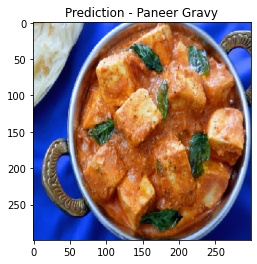

In [ ]:
predict_image('/content/drive/MyDrive/Nivarsha/Implementation/TestImages/paneergravy.jpg',model)

1/1 [==============================] - 0s 31ms/step


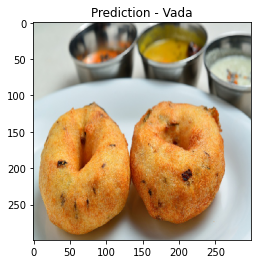

In [ ]:
predict_image('/content/drive/MyDrive/Nivarsha/Implementation/TestImages/vada.jpg',model)

1/1 [==============================] - 0s 31ms/step


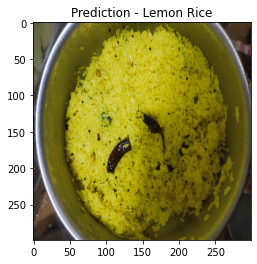

In [ ]:
predict_image('/content/drive/MyDrive/Nivarsha/Implementation/TestImages/LemonRice.jpg',model)

1/1 [==============================] - 0s 49ms/step


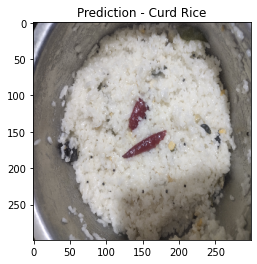

In [ ]:
predict_image('/content/drive/MyDrive/Nivarsha/Implementation/TestImages/CurdRice.jpg',model)

1/1 [==============================] - 0s 37ms/step


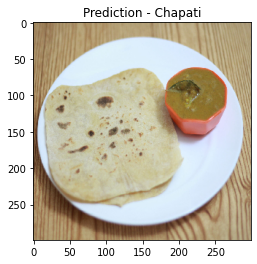

In [ ]:
predict_image('/content/drive/MyDrive/Nivarsha/Implementation/TestImages/chapati.jpg',model)

1/1 [==============================] - 0s 34ms/step


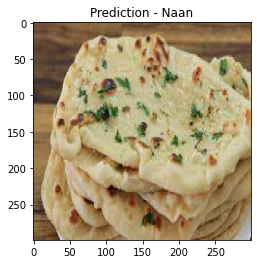

In [ ]:
predict_image('/content/drive/MyDrive/Nivarsha/Implementation/TestImages/Naan.jpg',model)